In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from scipy import stats

# Block Level Data 

In [8]:
blocks = pd.read_csv("../../../Data/refined_data/blocks50.csv", index_col='LOGRECNO')

In [9]:
blocks.head(2)

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our42075,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160
LOGRECNO,,,,,,,,,,,,,,,,,,,,,
8303,1102,389,26,9,34,0,27,0,19,7,...,0,81,0,38,4,21,0,0,18,0
8304,1061,470,33,31,43,20,31,0,15,6,...,0,103,0,56,23,9,0,0,15,0


In [10]:
blocks.shape

(15463, 1965)

In [11]:
attr = pd.read_csv("../../../Data/refined_data/attr_interconn.csv", index_col=0)

In [12]:
attr.head(2)

,Q_name,puma_attr,block_attr,ourID
0,B01001_sex by age_Total:_total:,0002_1,0002_1,our2
1,B01001_sex by age_Male:_male:,0002_2,0002_2,our3


In [7]:
attr.shape

(42796, 5)

In [14]:
features = pd.read_csv("../../../Data/refined_data/features_we_use.csv", index_col=0)

In [15]:
features.head(2)

,Q_name,puma_attr,block_attr,ourID
0,B01001_sex by age_Total:_total:,0002_1,0002_1,our2
1,B01001_sex by age_Male:_male:,0002_2,0002_2,our3


In [16]:
features.shape

(1965, 4)

In [19]:
predict = pd.read_csv("../../../Data/refined_data/predict.csv")[['internetP','label']]

In [20]:
predict.head(2)

,internetP,label
0,67.543117,train
1,62.167979,train


In [21]:
predict.shape

(5777, 2)

# Reading Puma Data

In [33]:
puma = pd.read_csv("../../../Data/refined_data/puma50.csv", index_col='st')

In [34]:
puma.head(2)

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,label
st,,,,,,,,,,,,,,,,,,,,,
il_129,710667,351639,22906,23456,24982,14097,8870,5073,4804,15555,...,85878,0,25100,29949,7047,74,2341,21367,768,train
wi_57,599168,288604,22838,22923,21190,12728,10750,7433,5315,13621,...,39792,39,12252,8283,8970,0,1870,8378,363,train


In [35]:
puma['label'].value_counts()

train    3696
test     1156
valid     925
Name: label, dtype: int64

In [36]:
pumadata=puma.copy()

# Percentages of internet Users

In [37]:
# internetper = predict['0165_11']/(predict['0165_10'])
internetper = predict['internetP'].astype(float)/100

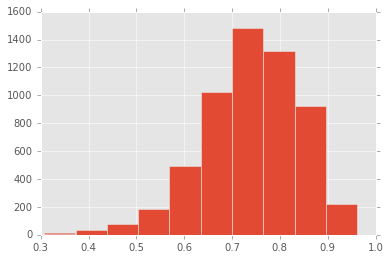

In [38]:
l=internetper.hist()

### Defining threshhold to divide data between 0 and 1 i.e. no internet connection or internet connection. percentage of internet users > median is 1 and less than median 0


In [39]:
# pumadata['internet']= internetper.apply(lambda x: 1 if x>=internetper.median() else 0)

## Giving dummy value to "st" id

In [40]:
# pumadata['st'] = pd.get_dummies(data=pumadata, columns=['st'], sparse=True)

### Dividing Data in Test Train and validation based on predifined labels. 
### And dropping labels

In [41]:
Xtrain = pumadata.loc[pumadata['label'] == 'train'].drop(['label'], axis=1)
Xtest = pumadata.loc[pumadata['label'] == 'test'].drop(['label'], axis=1)
Xvalid= pumadata.loc[pumadata['label'] == 'valid'].drop(['label'], axis=1)

Seperating Labels from each of training, testing and validation data sets so we are only left with features and labels stored in different variables.  

Converting each of the string nan values to numpy int nan values and converting all the features to numpy array

In [42]:
label_train = np.ravel(train[['internet']].values)
pred_train = train.drop(['internet'], axis=1)
pred_train = np.int64(pred_train.fillna(np.nan))

KeyError: "['internet'] not in index"

In [25]:
results = test.copy()
label_test = np.ravel(test[['internet']].values)
pred_test = test.drop(['internet'], axis=1)
feature_names = list(pred_test.columns.values)
pred_test = np.int64(pred_test.fillna(np.nan))

In [26]:
results1 = valid.copy()
label_valid = np.ravel(valid[['internet']].values)
pred_valid = valid.drop(['internet'], axis=1)
feature_names = list(pred_valid.columns.values)
pred_valid = np.int64(pred_valid.fillna(np.nan))

In [27]:
import multiprocessing
jobs=multiprocessing.cpu_count()

## Building Random Forest Classifier and training is over training data set. 
## Calculating Area Under Curve (AUC) score and accuracy 

In [28]:
num_trees = 100
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=jobs, min_samples_split=10, verbose=2, oob_score = True)
rf.fit(X=pred_train, y=label_train)

# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions
# get AUC score (produce probabilistic predictions)
print (roc_auc_score(label_test, rf_predictions))

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print (accuracy_score(label_test, rf_predictions_class, normalize=True))

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.1s remaining:    7.5s
[Parallel(n_jobs=4)]: Done  51 out of 100 | elapsed:    1.0s remaining:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished



0.941176470588


### Running same model on validation set calculate AUC score

In [29]:
rf_predictions = rf.predict_proba(pred_valid)[:, 1]
results1['v_pred'] = rf_predictions
print (roc_auc_score(label_valid, rf_predictions))

0.984919803111


[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


### Finding Accuracy of the score

In [30]:
rf_predictions_class = rf.predict(pred_valid)
print (accuracy_score(label_valid, rf_predictions_class, normalize=True))

0.935135135135


[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


### Cleaning block level data in same way as train, test and valid data set above

In [31]:
results2 = blocks.copy()
feature_names = list(blocks.columns.values)
pred_block = np.int64(blocks.fillna(np.nan))

In [32]:
pred_block.shape

(15463, 1966)

### Storing prediction probability in results 2

In [33]:
rf_predictions = rf.predict_proba(pred_block)[:, 1]
results2['preds'] = rf_predictions

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  51 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


# Using Random Forest Regressor

In [34]:
pumadata1=puma.copy()
pumadata1['internet']= predict['0165_11']
pumadata1['st'] = pd.get_dummies(data=pumadata, columns=['st'], sparse=True)


In [35]:
trainr = pumadata1.loc[pumadata1['label'] == 'train']
trainr = trainr.drop(['label'], axis=1)
testr = pumadata1.loc[pumadata1['label'] == 'test']
testr = testr.drop(['label'], axis=1)

In [36]:
validr= pumadata1.loc[pumadata1['label'] == 'valid']
validr = validr.drop(['label'], axis=1)

In [37]:
label_trainr = np.ravel(trainr[['internet']].values)
pred_trainr = trainr.drop(['internet'], axis=1)
pred_trainr = np.int64(pred_trainr.fillna(np.nan))

In [38]:
resultsValues = testr.copy()
label_testr = np.ravel(testr[['internet']].values)
pred_testr = testr.drop(['internet'], axis=1)
feature_namesr = list(pred_testr.columns.values)
pred_testr = np.int64(pred_testr.fillna(np.nan))

In [39]:
resultsValuesValid = validr.copy()
label_validr = np.ravel(validr[['internet']].values)
pred_validr = validr.drop(['internet'], axis=1)
feature_namesvr = list(pred_validr.columns.values)
pred_validr = np.int64(pred_validr.fillna(np.nan))

In [40]:
rfr = RandomForestRegressor(n_estimators=num_trees, criterion='mse', min_samples_split=10, verbose=2, oob_score = True)
rfr.fit(X=pred_trainr, y=label_trainr)



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:  2.5min



building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=2, warm_start=False)

In [41]:
#rfr_predictions = rfr.predict_proba(pred_testr)[:, 1]
#resultsValues['preds_proba'] = rfr_predictions
#get AUC score (produce probabilistic predictions)
#print (roc_auc_score(label_test, rf_predictions))

# get accuracy (predict the class)
rfr_predictions_class = rfr.predict(pred_testr)
rfr_score = rfr.score(X=pred_testr, y=label_testr)
rfr_scoreV = rfr.score(X=pred_validr, y=label_validr)
#print (accuracy_score(label_testr, np.round(rfr_predictions_class)))
print ("test set r score : ", rfr_score)
print ("validation set r score: ",rfr_scoreV  )

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


test set r score :  0.982924144048
validation set r score:  0.99428073853


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [53]:
feature_importance= list(rfr.feature_importances_)
feature_list = []
for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i],feature_importance[i]))
k= (sorted(feature_list,reverse=True,key=lambda x:x[1]))

In [71]:
df= pd.DataFrame(k,columns=['ourID','ImportanceValue'])

In [74]:
attimp=df.merge(attr,on='ourID')

In [75]:
attimp.to_csv("important_AttributesRF.csv")

In [42]:
resultsValues['preds']=rfr.predict(pred_testr)
resultsValuesValid['preds']=rfr.predict(pred_validr)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [43]:
##Head of predicted test set
resultsValues.head()

,st,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,internet,preds
4621,102165,102165,51565,4658,3566,3083,1769,1821,775,615,...,0,2939,3270,848,0,383,2766,31,28332,28966.514382
4622,101763,101763,51212,3158,3941,3091,2948,1408,611,224,...,54,4210,2240,985,0,620,3949,74,22018,25322.846087
4623,144007,144007,75625,5435,5259,5319,2681,2077,1176,1321,...,0,7677,2894,1235,0,126,8331,0,35822,35941.268116
4624,99220,99220,48773,3011,2953,3762,1759,1569,481,591,...,0,3010,4636,745,0,465,4414,200,25838,26402.763747
4625,110369,110369,55156,3149,3625,2197,2767,1513,284,1345,...,0,3348,2626,905,0,449,2224,126,34607,34348.725492


In [44]:
## Head of predicted validation set
resultsValuesValid.head()

,st,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,internet,preds
3696,142577,142577,70443,4276,6029,4276,3146,1117,1210,1253,...,0,3051,3570,2529,0,514,3198,152,33376,34406.346020
3697,114712,114712,56329,5500,4145,4643,2057,2006,499,1059,...,0,1811,858,931,0,458,2670,0,29793,29014.127660
3698,104489,104489,53074,4286,3672,2450,1920,1931,1659,944,...,0,3584,3493,1070,0,279,5147,0,29858,28689.504269
3699,140780,140780,68822,3264,4021,5030,3291,4604,1481,1887,...,0,3468,1942,1175,0,168,3849,173,29510,33141.595601
3700,108222,108222,51738,2849,3699,2808,2039,929,661,408,...,0,3556,4114,883,0,523,3093,0,35369,36271.118945


## Applying Model at Block Level

In [45]:
resultsblock = blocks.copy()
feature_names = list(resultsblock.columns.values)
pred_block = np.int64(resultsblock.fillna(np.nan))

In [46]:
resultsblock['pred_blck']=rfr.predict(pred_block)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [47]:
resultsblock.head()

,LOGRECNO,our2,our3,our4,our5,our6,our7,our8,our9,our10,...,our42152,our42153,our42154,our42155,our42156,our42157,our42158,our42159,our42160,pred_blck
0,8303,1102,389,26,9,34,0,27,0,19,...,81,0,38,4,21,0,0,18,0,10458.317890
1,8304,1061,470,33,31,43,20,31,0,15,...,103,0,56,23,9,0,0,15,0,10389.733168
2,8305,2828,1344,217,93,141,137,0,35,51,...,119,0,38,0,77,0,0,4,0,10428.182612
3,8306,764,341,31,0,21,14,0,21,14,...,44,0,29,0,0,0,0,15,0,10447.982636
4,8307,1365,751,81,56,168,36,81,0,0,...,157,0,92,36,14,0,0,15,0,10422.556400


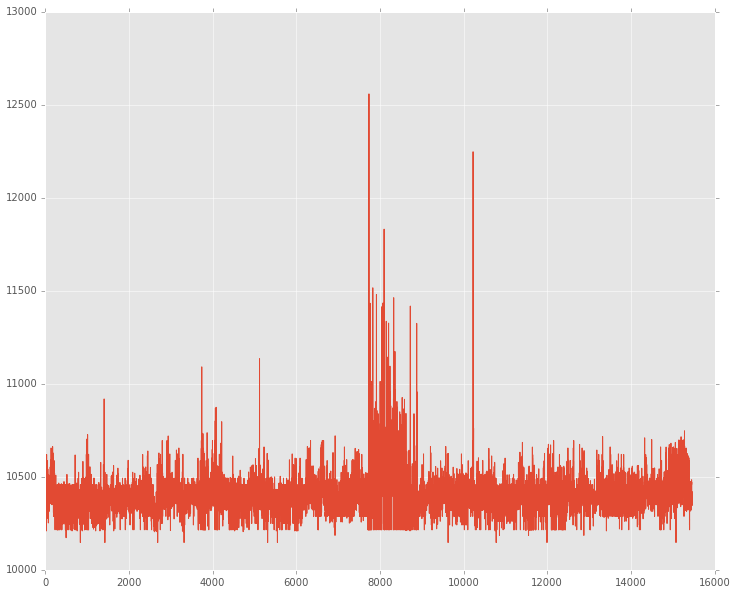

In [48]:
plt.figure(figsize=(12,10))
plt.plot(resultsblock['pred_blck'])